# Response Themes for "What new features or changes would you like to see in Jupyter Notebook? (Please list anything that comes to mind that helps you in your workflow, big or small.)"

* Goal: Extract theme keywords from `features_changes` responses.
* Data: Output from 2_clean_survey.ipynb notebook (`survey_short_columns.csv`)
* Process from [1_ux_survey_review.ipynb](1_ux_survey_review.ipynb):

> Moving forward, here's a semi-automatic procedure we can follow for identifying themes across questions:
> 1. Take a random sample of question responses
> 2. Write down common theme keywords
> 3. Search back through the responses using the theme keywords
> 4. Expand the set of keywords with other words seen in the search results
> 5. Repeat for all themes and questions
> Later, we can use a fully automated topic modeling approach to validate our manually generated themes.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

Make sure the samples come up the same for anyone that re-runs this.

In [4]:
rs = np.random.RandomState(123)

In [5]:
pd.set_option('max_colwidth', 1000)

In [6]:
df = pd.read_csv('survey_short_columns.csv')

In [7]:
def show(series):
    '''Make random samples easier to read.'''
    for i, value in enumerate(series):
        print('{}) {}'.format(i, value), end='\n\n')

In [8]:
responses = pd.concat([df.features_changes_1, df.features_changes_2, df.features_changes_3])

In [9]:
assert len(responses) == len(df) * 3

In [10]:
responses.isnull().value_counts()

True     3972
False    1146
dtype: int64

In [11]:
responses = responses.dropna()

## Initial Samples

I ran the sampling code below multiple times and manually built up the initial set of keywords seen commonly across them. I formed groups of conceptually related keywords. Then I tried to assign a simple label to each group.

In [12]:
show(responses.sample(20, random_state=rs))

0) sort files in folders

1) Well-documented extensions framework

2) Easy (CSS) customization of basic settings (code block themes, fonts, etc.)

3) Debug capabilities / "Workspace explorer"

4) Drag and drop for cells

5) Tighter integration of qtconsole

6) Googling for IPython notebook issues turns up tons of legacy  solutions; what's the current right way?

7) Stylesheets configuration

8) External editor

9) Allow hiding of code blocks when rendering to html/md

10) Native wrapper for saving and opening

11) https://github.com/jupyter/notebook/issues/389#issuecomment-154087320

12) Brainless cloud developement

13) Export non-code elements (Markdown and plots)

14) Built-in compatibility with git

15) Easier access to text editing

16) drag/drop of cells

17) Web API documentation

18) metadata editing within the notebook

19) small: add  So I can run jupyter as a standalone app on android with the kernel running in a chroot environment.



In [13]:
themes = {
    'ux': ['drag', 'drop', 'drag(/|&)drop', '(multiple|groups of|individual) cells', 'sections', 
           'click(ing)?', 'paste', 'undo', 'all cells', 'copy/paste', 
           'todo', '(styles?|stylesheets?|CSS|theme|skin|font|colo(u)?r)', 'scrol(ling)?', 
           'fold(ing)?(.*cells)?', 'collaps(e|ing|ible)', 'hid(e|ing|den)',
           'navigat(e|ion|ing)', 
           '(menus?|icons?|buttons?|tooltips?)', 'g?ui($|\W)', 
           'mobile', 'progress bar', 
           '(window|pane|sidebar|screen|width|height)', '(moving|reordering) cells', 'toggle',
           'spell(\s|-)?check(er|ing)?', 'dialog', ],
    'version_control': ['(source|version) (control|tracking|management)', 'git(hub)?',
                        'control version', 'not versioned', 'version-controlled', 
                        'version(ing)?(\snotebooks)?', '((version|editing) history)|revisions', 'revisions/code', 
                        'change track(er|ing)', ],
    'dissemination': ['hid(e|ing) (code|cells|input)', 'slides?', 'deployment', 'nbconvert', 'nbviewer', 
                      'dashboards?',
                      'report(ing)?', 'interact(ion|ive|ity)', 'presentations?', 'knitr', 
                      'export', 'slides(how)?', 'sharing', 'publish(ing)?', 'PDF($|\W)', 'download', 'reus(e|able)', ], 
    'documentation': ['doc(s|umentation)?($|\W)', 'tutorials?', 'instructions?', 'how(\s|-)?tos?' ],
    'ide': ['workspace|ide($|\W)|rstudio', 'variable (explorer|viewer)', 'debug', 'profil(er|ing)', 'breakpoints?', 
            'inspector', 'variables', 'pdb', ],
    'hosting': ['cloud', 'cluster', 'jupyter(\s)?hub', 'tmpnb', 'desktop', 'S3', 'backup', 'docker', 
                'install', 'hosting', 'users', 'multi(ple|-)?\s?user', ],
    'content_management': ['(folders?|director(y|ies))', 'file(\s)?system', '(toc|table of contents)', 'search', 
                           'tagging', 'file (manager|browser)', 'hierarchy', 'find\s?(\/|and\s)replace', 
                           'import(able)? (from)? notebooks?', 'import', 'refactor(ing)?', ], 
    'collab': ['collaborat(ion|ive|ing)', ],
    'editor': ['lint(ing|er)s?', '(better|powerful|external) edit(or|ing)', 
               'multi(ple\s|-)cursor', '(text|code) edit(or|ing)', 'syntax', 'diffs?($|\W)',
               'curser', 'vim?($|\W)|sublime|atom|emacs', 
               '(tab|code|auto)-?\s?complet(e|ion)', '(hot)?key(\s|-)?(mappings|bindings)', 'keyboard|short-?cuts?', 
               'parenthes(e|i)s', ],
    'integration': ['integrat(e|ion)', '(apache\s)?spark', 'pydb', 'matplotlib', 'django', 
                    'pandoc', 'wordpress', 'pyflakes', 'third-party', 'packages', ],
    'visualization': ['d3', 'widgets', 'visualization', 'plotting', 'graphics', ],
    'cranky': ['dial down the hype', ], 
    'performance': ['performance', 'more speed', 'cach(e|ing)', ],
    'compatibility': ['communication of changes', 'package updates', 'compatib(ility|le)', ],
    'language': ['python', 'language', 'clojure', 'fortran', 'javascript', 'R($|\W)', 'C\/C', ],
    'cli': ['cli($|\W)', 'terminal', 'command line', 'console', ],
}

## Coverage Improvement

I next ran the code below to associate the theme labels with the responses. I then iterated on running the code below to find reponses without labels. I expanded the list of keywords and themes above in order to improve coverage.

In [14]:
import re

In [15]:
def keywords_or(text, keywords):
    for keyword in keywords:
        if re.search('(^|\W+){}'.format(keyword), text, re.IGNORECASE):
            return True
    return False

In [16]:
def tag_themes(responses, themes):
    tagged = responses.to_frame()
    tagged['themes'] = ''
    for theme, keywords in themes.items():
        results = responses.map(lambda text: keywords_or(text, keywords))
        tagged.loc[results, 'themes'] += theme + ','
        print(theme, results.sum())
    return tagged

In [17]:
tagged = tag_themes(responses, themes)
tagged.themes.str.count(',').value_counts()

dissemination 112
ide 102
compatibility 5
cli 23
ux 267
version_control 106
hosting 63
performance 5
visualization 48
cranky 1
documentation 32
collab 23
editor 128
content_management 67
integration 126
language 55


1    659
0    257
2    192
3     33
4      4
5      1
Name: themes, dtype: int64

In [18]:
tagged[tagged.themes.str.len() == 0].sample(20, random_state=rs)

,0,themes
1064,Persist sessions,
259,continue to document,
254,open / edit text file in cell,
353,"more packaged extensions (or make configuration more straightforward, it's now especially confusing with switch from ipython to jupyter)",
1494,Bundle a VE with a notebook,
504,better save,
1520,Citations,
155,Better handling for big output..,
1035,copyable plaintext markdown results,
919,see from previous answers,


## Precision Check

I then studied a sample of responses for each theme to see if there major inaccuracies in their application (e.g., string matches that are too fuzzy).

In [19]:
tagged = tag_themes(responses, themes)
tagged.themes.str.count(',').value_counts()

dissemination 112
ide 102
compatibility 5
cli 23
ux 267
version_control 106
hosting 63
performance 5
visualization 48
cranky 1
documentation 32
collab 23
editor 128
content_management 67
integration 126
language 55


1    659
0    257
2    192
3     33
4      4
5      1
Name: themes, dtype: int64

In [20]:
from IPython.display import display, clear_output

In [21]:
# for key in themes:
#     clear_output()
#     size = min([10, len(tagged[tagged.themes.str.contains(key)])])
#     display(tagged[tagged.themes.str.contains(key)].sample(size))
#     if input('Showing `{}`. Type Enter to continue, "q" to stop.'.format(key)) == 'q':
#         break

I also looked at responses with multiple themes to fine tune them, and catch duplication of words in multiple themes.

In [22]:
tagged[tagged.themes.str.count(',') == 2].sample(20, random_state=rs)

,0,themes
594,hints on keyboard shortcuts in menus,"ux,editor,"
418,Did I mention git integration?,"version_control,integration,"
646,hide header and toolbar and remember my setting!,"ide,ux,"
1604,Better tutorials for setting up eg jupyterhub and tmpnb,"hosting,documentation,"
824,Git integration,"version_control,integration,"
273,File hierarchy (wiki style),"ux,content_management,"
472,git integration,"version_control,integration,"
505,Better Jupyter Hub admin docs,"hosting,documentation,"
1515,Collaboration support in jupyter hub,"hosting,collab,"
1270,better versioning/collaborative access tools,"version_control,collab,"


## Keyword Frequencies

In [23]:
import matplotlib
import seaborn

In [24]:
counts = {}

In [25]:
for theme, keywords in themes.items():
    for keyword in keywords:
        hits = responses.map(lambda text: keywords_or(text, [keyword]))
        counts[keyword] = hits.sum()

In [26]:
hist = pd.Series(counts).sort_values()

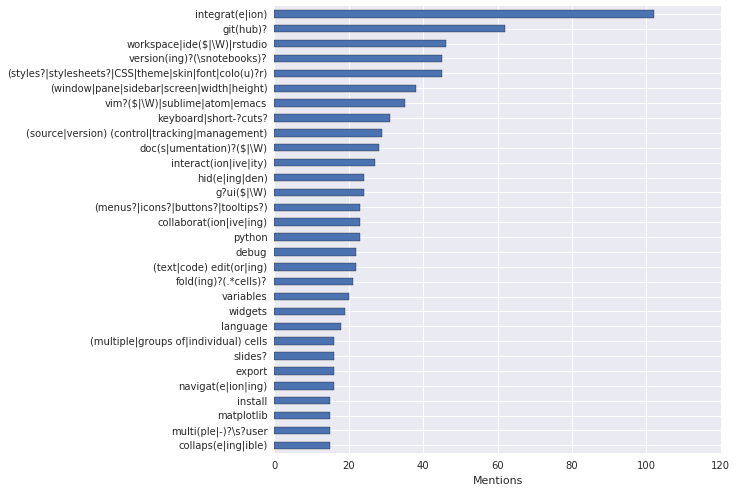

In [27]:
ax = hist[-30:].plot.barh(figsize=(8, 8))
_ = ax.set_xlabel('Mentions')

## Persist

I save off the themes and keywords to a DataFrame with the same index as the original so that the entries can be tagged.

In [28]:
column = 'features_changes'

In [29]:
themes_df = tagged.themes.to_frame()

In [30]:
themes_df = themes_df.rename(columns={'themes' : column+'_themes'})

In [31]:
themes_df[column+'_keywords'] = ''

In [32]:
for theme, keywords in themes.items():
    for keyword in keywords:
        results = responses.map(lambda text: keywords_or(text, [keyword]))
        themes_df.loc[results, column+'_keywords'] += keyword + ','

In [33]:
themes_df[column+'_themes'] = themes_df[column+'_themes'].str.rstrip(',')
themes_df[column+'_keywords'] = themes_df[column+'_keywords'].str.rstrip(',')

Up above, I merged the three response fields for the question into one common pool which means we can have duplicate index value in the themes DataFrame. We need to squash these down and remove duplicates.

In [34]:
def union(group_df):
    '''Gets the set union of themes and keywords for a given DataFrame.'''
    themes = group_df[column+'_themes'].str.cat(sep=',')
    themes = list(set(themes.split(',')))
    themes = ','.join(theme for theme in themes if theme)
    
    keywords = group_df[column+'_keywords'].str.cat(sep=',')
    keywords = list(set(keywords.split(',')))
    keywords = ','.join(keyword for keyword in keywords if keyword)
    return pd.Series([themes, keywords], index=[column+'_themes', column+'_keywords'])

We group by the index and union the themes and keywords.

In [35]:
themes_df = themes_df.groupby(themes_df.index).apply(union)

In [36]:
themes_df.head()

,features_changes_themes,features_changes_keywords
1,"editor,cli,version_control","command line,git(hub)?,diffs?($|\W)"
5,"dissemination,ide,visualization,cli,integration","graphics,variables,matplotlib,workspace|ide($|\W)|rstudio,terminal,interact(ion|ive|ity)"
6,"hosting,dissemination,documentation","slides(how)?,download,PDF($|\W),nbconvert,doc(s|umentation)?($|\W),slides?,jupyter(\s)?hub"
7,dissemination,"knitr,report(ing)?,dashboards?"
9,,


The themes DataFrame should have as many rows as there are non-null responses in the original DataFrame.

In [37]:
assert len(themes_df) == len(df[[column+'_1', column+'_2', column+'_3']].dropna(how='all'))

In [38]:
themes_df.to_csv(column + '_themes.csv', sep=';')